## Import Library

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
import numpy as np

## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')
raw_data_path='drive/MyDrive/project/'
os.listdir(raw_data_path)

Mounted at /content/drive


['plain_text',
 'dataset.zip',
 'Face_Recognition.ipynb',
 'dataset',
 'dataset_cropped',
 'vgg.ipynb',
 'model.pt',
 'VGG_GoogleNet_ResNet_(Template) (1).ipynb',
 'runs',
 'entire_model.pt',
 'Face_Recognition-Fariz.ipynb',
 'face_rec.ipynb']

### Labels

In [4]:
labels_path = raw_data_path + "plain_text"

raw_labels = pd.read_csv(labels_path+"/list_attribute.txt", skipinitialspace= True, delim_whitespace=True, skiprows=1)
raw_labels = raw_labels.replace(to_replace=-1, value=0)
raw_labels.insert(loc=0, column='img_number', value=np.arange(1,len(raw_labels)+1))

print(raw_labels.shape)
print(len(raw_labels.index.to_list()))
display(raw_labels.head())
print(f'Raw Labels: {raw_labels.shape[0]} rows')
img_path = raw_data_path + 'dataset/train'
raw_imgs_len = len(os.listdir(img_path))
print(raw_imgs_len)

labels = raw_labels[raw_labels.index.isin(os.listdir(img_path))]
display(labels.head())
print(f'Labels: {labels.shape[0]} rows')
print(f'Gender col_id: {labels.columns.get_loc("Male")}, Data 1 gender: {labels.iloc[0,labels.columns.get_loc("Male")]}')


(202599, 41)
202599


,img_number,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,1,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,2,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,3,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,4,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,5,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Raw Labels: 202599 rows
5017


,img_number,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000051.jpg,51,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
000052.jpg,52,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
000065.jpg,65,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
000166.jpg,166,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
000198.jpg,198,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


Labels: 5000 rows
Gender col_id: 21, Data 1 gender: 1


## Preprocessing

In [5]:
# DATA AUGMENTATION

from torchvision.transforms import v2

# H, W = 32, 32
# img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

default_normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
default_type = v2.ToDtype(torch.float32, scale=True)

# Transformer for train data
def transform_train_data(normalize=default_normalize, dtype=default_type, jitter_param= 0.4):
    return v2.Compose([
        v2.Resize(480),
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=jitter_param, contrast=jitter_param,
                                     saturation=jitter_param),
        dtype,
        normalize
    ])

# Transformer for validation data
def transform_test_data(normalize=default_normalize, dtype=default_type):
    return v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        dtype,
        normalize
    ])

In [6]:
from torchvision.io import read_image
class  GenderDataset(Dataset):
    def __init__(self, labels, img_path, transform=None, target_transform=None):
        self.labels = labels
        self.img_path = img_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def load_img(self, idx):
        label_id = self.labels.iloc[idx, 0]
        img_name = f'{label_id:06d}.jpg'
        img_path = os.path.join(self.img_path, img_name)
        return read_image(img_path)

    def __getitem__(self, idx):
        image = self.load_img(idx)

        if self.transform:
            image = self.transform(image)

        g_id = self.labels.columns.get_loc("Male")
        gender = self.labels.iloc[idx, g_id]
        return image, torch.tensor(gender, dtype=torch.long)
        # return image, gender

## Helper

In [7]:
import time
class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.

    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)

### Model training helper

In [104]:
def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):

    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    y_preds=[]
    ys = []

    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        ys.extend(y.cpu().numpy())
        # forward
        y_pred = model(x)
        y_preds.extend(y_pred.cpu().numpy())
        # loss_batch = loss_fn(y_pred, y)

        # Create one-hot encoded labels
        one_hot_labels = torch.zeros(y.size(0), 2).to(device)
        one_hot_labels[range(y.size(0)), y] = 1  #  0 (not male) and 1 (male)
        loss_batch = loss_fn(y_pred, one_hot_labels)

        if model.training:
            # backward & update weights
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]

        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1

        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)

    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}

    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    # return loss, metrics
    return loss, metrics, x, ys, y_preds

In [105]:
import warnings

warnings.filterwarnings("ignore")

In [106]:
# !pip install facenet-pytorch
# from facenet_pytorch import InceptionResnetV1
# import copy

def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

def train_model(model, dataloaders, optimizer, scheduler, criterion, lr, num_epochs, metrics=metrics, device= device):
    writer = SummaryWriter()
    writer.iteration, writer.interval = 0, 10

    print('\n\nInitial')
    print('-' * 10)
    model.eval()
    with torch.no_grad():
        pass_epoch(
            model, criterion, dataloaders["test"],
            batch_metrics=metrics, show_running=True, device=device,
            writer=writer
        )

    # loss_train = []
    # loss_test = []
    # metrics_train = []
    # metrics_test = []
    # y_pred = []
    # metrics_test = []

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        model.train()
        pass_epoch(
            model, criterion, dataloaders["train"], optimizer, scheduler,
            batch_metrics=metrics, show_running=True, device=device,
            writer=writer
        )

        model.eval()
        with torch.no_grad():
            pass_epoch(
                model, criterion, dataloaders["test"],
                batch_metrics=metrics, show_running=True, device=device,
                writer=writer
            )

    writer.close()


Running on device: cuda:0


## Preparation

In [107]:
import multiprocessing
from sklearn.model_selection import train_test_split

# number of pre-processing workers (automatically detect the number of workers)
workers = multiprocessing.cpu_count()
print("workers: {}".format(workers))

# training batch size per device (CPU/GPU)
# Used batch size = 64 for resnet18_v1,resnet18_v2,resnet34_v1,resnet34_v2,resnet50_v1,resnet50_v2,resnet101_v1,
#resnet101_v2
#Used batch size=32 for resnet152_v1,resnet152_v2
batch_size = 32


# Split the dataset into training and validation sets
labels_train, labels_test = train_test_split(labels, test_size=0.1, random_state=42)

train_set = GenderDataset(labels_train, img_path, transform_train_data())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=workers)


test_set = GenderDataset(labels_test, img_path, transform_test_data())
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=workers)

workers: 2


## Modelling

In [108]:
# Define loss
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss() # DANGER: already softmax. no need to do softmax beforehand

# number of training epochs
num_epochs = 10

# learning rate
lr = 0.001

dataloaders = {
    "train":train_loader, "test":test_loader
}
# dataset_sizes= {
#     "train":len(train_set), "test":len(test_set)
# }

In [109]:
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR

model = resnet50(weights="IMAGENET1K_V2").to(device)

## Freeze all the pre-trained layers because our dataset it used bigger dataset
# for param in model.parameters():
#     param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2).to(device)  # Assuming 2 classes for binary classification

optimizer = optim.Adam(model.parameters(), lr=lr, )
scheduler = MultiStepLR(optimizer, [5, 10])


## Training

In [59]:
import warnings
warnings.filterwarnings("ignore")

train_model(model, dataloaders, optimizer, scheduler, criterion, lr, num_epochs)
os.listdir(raw_data_path)



Initial
----------
Valid |    16/16   | loss:    0.6906 | fps:  248.0369 | acc:    0.4453   

Epoch 1/10
----------
Train |   141/141  | loss:    0.3989 | fps:   92.3795 | acc:    0.8139   
Valid |    16/16   | loss:    1.1325 | fps:  246.9004 | acc:    0.6176   

Epoch 2/10
----------
Train |   141/141  | loss:    0.2826 | fps:   95.1483 | acc:    0.8753   
Valid |    16/16   | loss:    0.1499 | fps:  240.6173 | acc:    0.9473   

Epoch 3/10
----------
Train |   141/141  | loss:    0.2508 | fps:   94.9097 | acc:    0.8911   
Valid |    16/16   | loss:    0.1460 | fps:  206.7078 | acc:    0.9492   

Epoch 4/10
----------
Train |   141/141  | loss:    0.2202 | fps:   95.2909 | acc:    0.9082   
Valid |    16/16   | loss:    0.1596 | fps:  171.1117 | acc:    0.9363   

Epoch 5/10
----------
Train |   141/141  | loss:    0.2134 | fps:   95.2425 | acc:    0.9059   
Valid |    16/16   | loss:    0.2921 | fps:  189.6789 | acc:    0.8789   

Epoch 6/10
----------
Train |   141/141  | loss: 

['plain_text',
 'dataset.zip',
 'Face_Recognition.ipynb',
 'dataset',
 'dataset_cropped',
 'vgg.ipynb',
 'model.pt',
 'VGG_GoogleNet_ResNet_(Template) (1).ipynb',
 'runs',
 'entire_model.pt',
 'Face_Recognition-Fariz.ipynb',
 'face_rec.ipynb']

## Save the model

In [60]:
torch.save(model.state_dict(), raw_data_path + "model.pt")
torch.save(model, raw_data_path + "entire_model.pt")
os.listdir(raw_data_path)

['plain_text',
 'dataset.zip',
 'Face_Recognition.ipynb',
 'dataset',
 'dataset_cropped',
 'vgg.ipynb',
 'model.pt',
 'VGG_GoogleNet_ResNet_(Template) (1).ipynb',
 'runs',
 'entire_model.pt',
 'Face_Recognition-Fariz.ipynb',
 'face_rec.ipynb']

## Validation

In [135]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, dataloader, criterion,  metrics=metrics, device= device):
    writer = SummaryWriter()
    writer.iteration, writer.interval = 0, 10

    # a = None
    # b= None
    # c= None
    # d= None
    # e=None

    model.eval()
    ys = []
    y_preds = []

    with torch.no_grad():
        for inputs, y in test_loader:

            outputs = model(inputs.to(device))
            _, preds = torch.max(outputs, 1)
            ys.extend(y.cpu().numpy())
            y_preds.extend(preds.cpu().numpy())

    # with torch.no_grad():

    #     a,b,c,d,e = pass_epoch(
    #         model, criterion, dataloader,
    #         batch_metrics=metrics, show_running=True, device=device,
    #         writer=writer
    #     )
    acc = accuracy_score(ys, y_preds)
    writer.close()
    return acc,ys,y_preds

In [119]:
labels_val, labels_val2 = train_test_split(labels, test_size=0.1, random_state=42)

val_set = GenderDataset(labels_val, img_path, transform_test_data())
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=workers)

In [120]:
final_model = torch.load(raw_data_path + "entire_model.pt")

In [136]:
acc,ys, y_preds = evaluate_model(final_model, val_loader,criterion)

In [137]:
from sklearn.metrics import classification_report

# _y = np.concatenate(y)
# _ypred= np.concatenate(y_pred)

print(f"Accuracy: {acc * 100:.2f}%")

report = classification_report(ys, y_preds)
print("Classification Report:")
print(report)

Accuracy: 97.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       297
           1       0.97      0.97      0.97       203

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



## Visualize

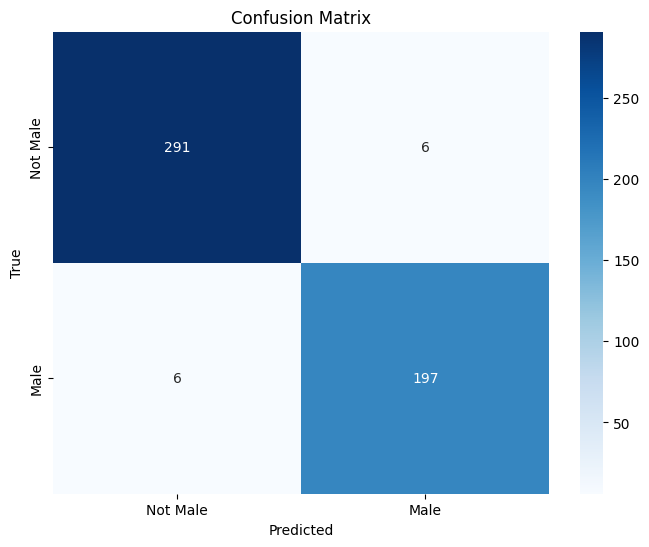

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(ys, y_preds)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Male', 'Male'], yticklabels=['Not Male', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

True vs Pred
['F', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M']


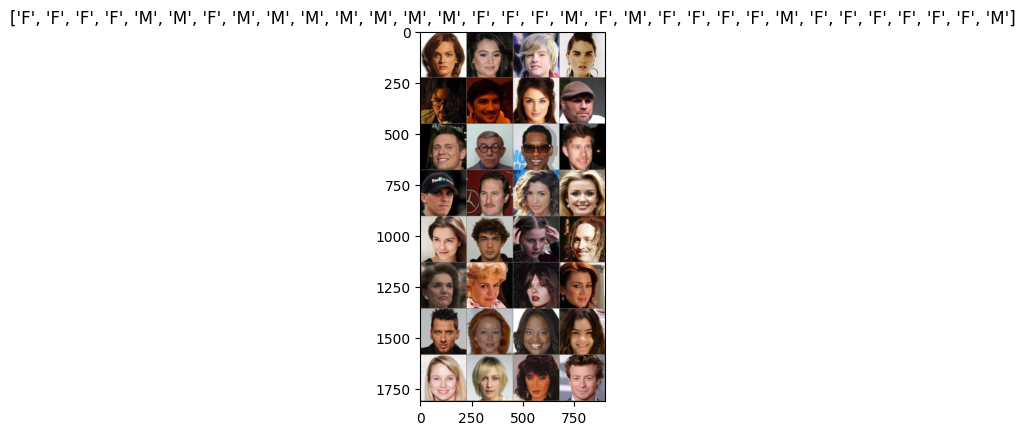

In [154]:
from torchvision import utils

final_model.eval()

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

val_set2 = GenderDataset(labels_val2, img_path, transform_test_data())
val_loader2 = DataLoader(val_set2, batch_size=batch_size, shuffle=True, num_workers=workers)

def label_to_string(labs):
    return ["F" if p == 0 else "M" for p in labs]

with torch.no_grad():
      inputs, labels = next(iter(val_loader2))
      imgs = inputs.to(device)
      ys = labels.detach().cpu().numpy()

      y_preds = final_model(imgs)
      _, preds = torch.max(y_preds, 1)
      out = utils.make_grid(inputs, nrow=4)
      print("True vs Pred")
      print(f"{label_to_string(ys)}")
      imshow(out, title=label_to_string(preds))



# Conclusion
- There are some miss labeling
- The data are imbalanced